# Predict pseudobulks

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-08 18:11:05.064856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 18:11:05.065293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 18:11:05.067719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 18:11:05.073859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736385065.083735 2537248 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736385065.08

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE180661_pseudobulks/"
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"


exp_id = "all-cellType"

if exp_id == "all-cellType":
    res_id = "cellType" # cellType subtype celltype_granular
elif exp_id == "all-granular":
    res_id = "celltype_granular"
elif exp_id == "all_subtype":
    res_id = "subtype"


curr_treatment = "drug"

in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"

subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"


In [3]:
adata = sc.read_h5ad(in_ad_file)

subtype_df = pd.read_csv(subtype_file, sep="\t")

if res_id == "subtype":
    adata.obs = adata.obs.rename({'IMR':'scIMR', 'DIF':'scDIF', 'PRO':'scPRO', 'MES':'scMES'}, axis=1)
    cell_types = ["scIMR", "scDIF", "scPRO", "scMES"]
elif res_id == "cellType":
    cell_types = ["B cells", "DC", "Macrophages", 
                "Mast cells", "Monocytes", "NK cells", "Plasma cells",
                "T cells", "Endothelial cells", "Fibroblasts",
                "Epithelial cells"]
    cell_types = ["T.cell", "Ovarian.cancer.cell", "Fibroblast", 
                  "Monocyte", "B.cell", "Endothelial.cell", 
                  "Plasma.cell"]
else: # granular
    cell_types = ["immune", "stromal", "tumor"]



In [4]:
# append to obs they should be in exactly the same order
subtype_df.index = adata.obs.index
adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

In [5]:

Y_full = adata.obs[cell_types]
Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
adata.obs["Y_max"] = Y_max

In [6]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,Ovarian.cancer.cell,Fibroblast,Endothelial.cell,Monocyte,T.cell,B.cell,Plasma.cell,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max
0,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.215000,0.010000,0.260000,0.045000,0.215000,0.175000,0.080000,0.394,0.512,0.036,0.058,DIF,Endothelial.cell
1,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.030000,0.100000,0.030000,0.270000,0.020000,0.330000,0.220000,0.794,0.042,0.012,0.152,IMR,B.cell
2,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.380000,0.090000,0.025000,0.210000,0.045000,0.240000,0.010000,0.462,0.350,0.042,0.146,IMR,Ovarian.cancer.cell
3,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.020000,0.435000,0.165000,0.115000,0.070000,0.005000,0.190000,0.032,0.022,0.048,0.898,MES,Fibroblast
4,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.585000,0.220000,0.060000,0.015000,0.085000,0.030000,0.005000,0.098,0.498,0.140,0.264,DIF,Ovarian.cancer.cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.008510,0.000712,0.009851,0.005425,0.003097,0.002376,0.970029,0.422,0.358,0.114,0.106,IMR,Plasma.cell
33996,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.005479,0.028999,0.008132,0.002173,0.015892,0.016113,0.923213,0.360,0.256,0.192,0.192,IMR,Plasma.cell
33997,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.003576,0.005394,0.004032,0.001560,0.017317,0.008581,0.959540,0.448,0.222,0.152,0.178,IMR,Plasma.cell
33998,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.018103,0.013037,0.034055,0.012250,0.081302,0.013003,0.828250,0.406,0.258,0.152,0.184,IMR,Plasma.cell


# Plot

In [7]:
sc.tl.pca(adata, n_comps=50)


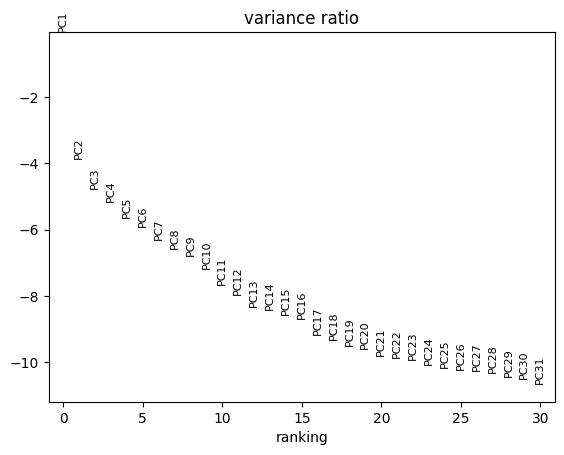

In [8]:
sc.pl.pca_variance_ratio(adata, log=True)


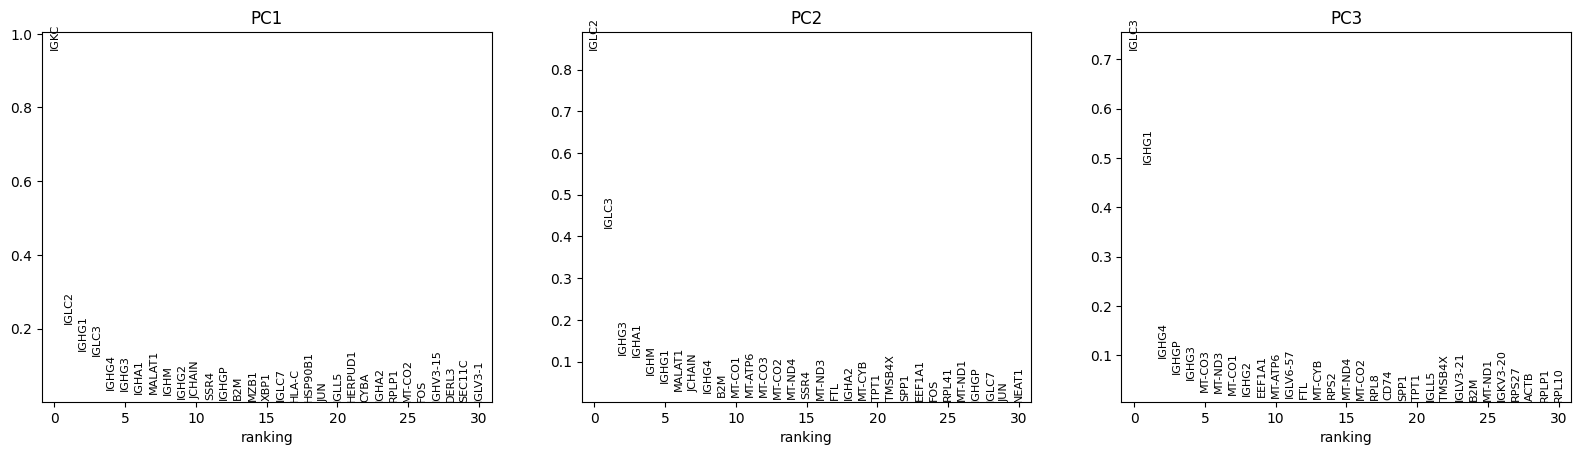

In [9]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [10]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


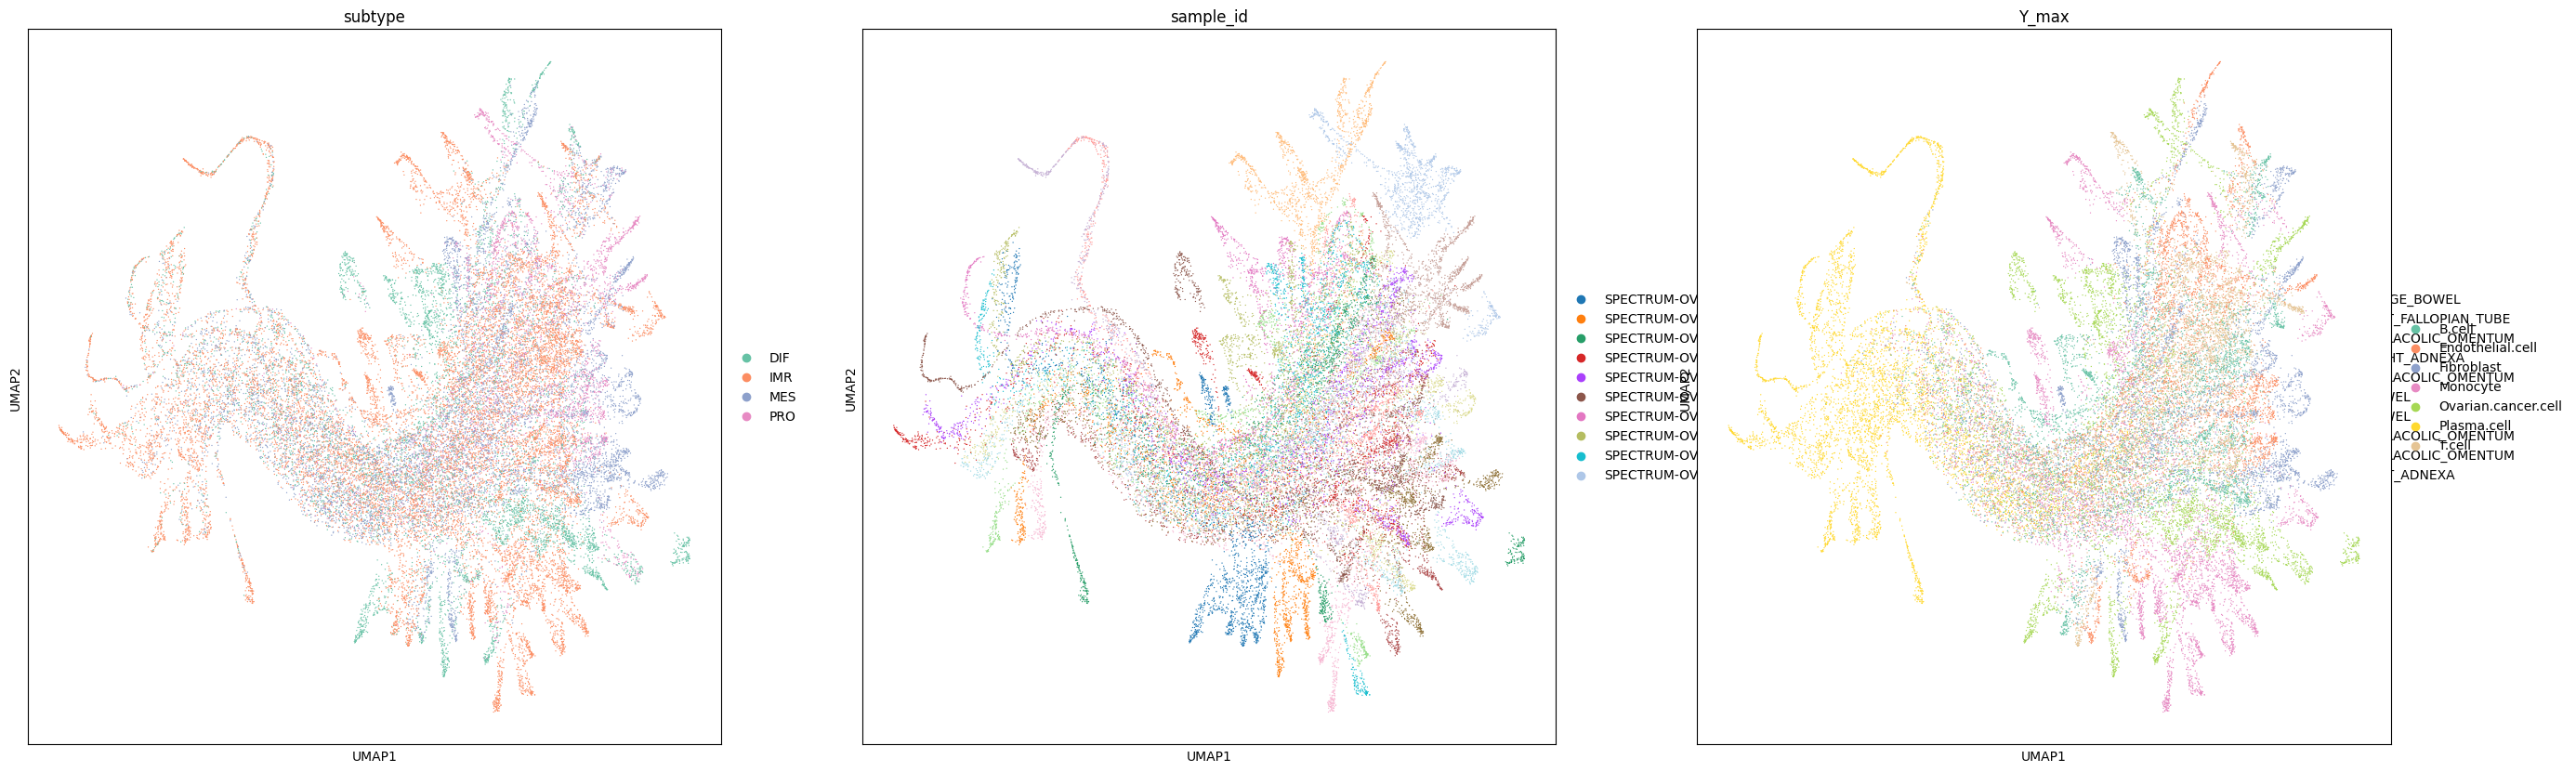

In [11]:
from matplotlib.pyplot import rc_context

# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color=['subtype', 'sample_id', "Y_max"])


In [12]:
tab = adata.obs.groupby(['Y_max', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
Y_max,,,,
B.cell,435,3298,900,206
Endothelial.cell,1221,664,1154,1793
Fibroblast,31,135,4221,376
Monocyte,30,4557,211,11
Ovarian.cancer.cell,3706,311,114,761
Plasma.cell,675,2959,1140,143
T.cell,286,3783,736,143


In [13]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY,442,931,324,3
SPECTRUM-OV-009_S1_BOWEL,489,796,401,14
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM,339,781,469,111
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM,264,1108,168,160
SPECTRUM-OV-036_S1_LEFT_ADNEXA,343,912,332,113
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,278,734,459,229
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM,367,761,393,179
SPECTRUM-OV-053_S1_LEFT_OVARY,496,665,397,142
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM,359,790,343,208


In [14]:
set(adata.obs.Y_max)

{'B.cell',
 'Endothelial.cell',
 'Fibroblast',
 'Monocyte',
 'Ovarian.cancer.cell',
 'Plasma.cell',
 'T.cell'}

In [15]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size() # Epithelial cells
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY,442,931,324,3
SPECTRUM-OV-009_S1_BOWEL,489,796,401,14
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM,339,781,469,111
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM,264,1108,168,160
SPECTRUM-OV-036_S1_LEFT_ADNEXA,343,912,332,113
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,278,734,459,229
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM,367,761,393,179
SPECTRUM-OV-053_S1_LEFT_OVARY,496,665,397,142
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM,359,790,343,208


In [16]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "Ovarian.cancer.cell")[0]].groupby(['sample_id', 'subtype']).size() # Epithelial cells
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY,225,41,0,0
SPECTRUM-OV-009_S1_BOWEL,238,6,1,0
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM,232,10,6,2
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM,197,38,0,3
SPECTRUM-OV-036_S1_LEFT_ADNEXA,207,16,4,10
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,205,9,2,35
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM,230,19,3,12
SPECTRUM-OV-053_S1_LEFT_OVARY,221,0,1,1
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM,229,10,2,7


# set the label for Diff Exp

In [17]:
# set the label

cell_type_vec = np.array(["DIF_total"]*adata.obs.sample_id.shape[0])
pro_label_idx = np.where(adata.obs.sample_id.isin(["SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM", "SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM"]) )[0]
cell_type_vec[pro_label_idx] = "PRO_total"

adata.obs['subtype_total'] = cell_type_vec



In [18]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "Fibroblast")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY,9,20,198,1
SPECTRUM-OV-009_S1_BOWEL,2,2,232,0
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM,0,0,244,0
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM,2,27,106,83
SPECTRUM-OV-036_S1_LEFT_ADNEXA,0,1,184,32
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,0,0,247,5
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM,0,1,232,13
SPECTRUM-OV-053_S1_LEFT_OVARY,4,0,215,27
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM,0,0,161,72


In [19]:
immune_ct = ["Monocyte"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY,0,100,0,0
SPECTRUM-OV-009_S1_BOWEL,0,100,0,0
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM,0,100,0,0
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM,0,100,0,0
SPECTRUM-OV-036_S1_LEFT_ADNEXA,0,100,0,0
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,0,100,0,0
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM,0,100,0,0
SPECTRUM-OV-053_S1_LEFT_OVARY,0,100,0,0
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM,0,100,0,0


In [20]:
immune_ct = ["B.cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY,6,92,1,1
SPECTRUM-OV-009_S1_BOWEL,3,85,12,0
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM,3,81,16,0
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM,0,100,0,0
SPECTRUM-OV-036_S1_LEFT_ADNEXA,1,98,1,0
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,2,79,14,5
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM,4,91,4,1
SPECTRUM-OV-053_S1_LEFT_OVARY,4,92,4,0
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM,4,93,3,0


In [21]:
immune_ct = ["T.cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY,4,94,2,0
SPECTRUM-OV-009_S1_BOWEL,0,96,4,0
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM,0,95,5,0
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM,0,100,0,0
SPECTRUM-OV-036_S1_LEFT_ADNEXA,0,100,0,0
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,0,96,4,0
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM,0,97,3,0
SPECTRUM-OV-053_S1_LEFT_OVARY,3,95,2,0
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM,0,99,1,0


# Differential Expression

In [22]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# now process the counts further for doing  
# analysis and the cell clustering
#adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=10)

# calculate PCA
sc.tl.pca(adata, n_comps=20)

# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


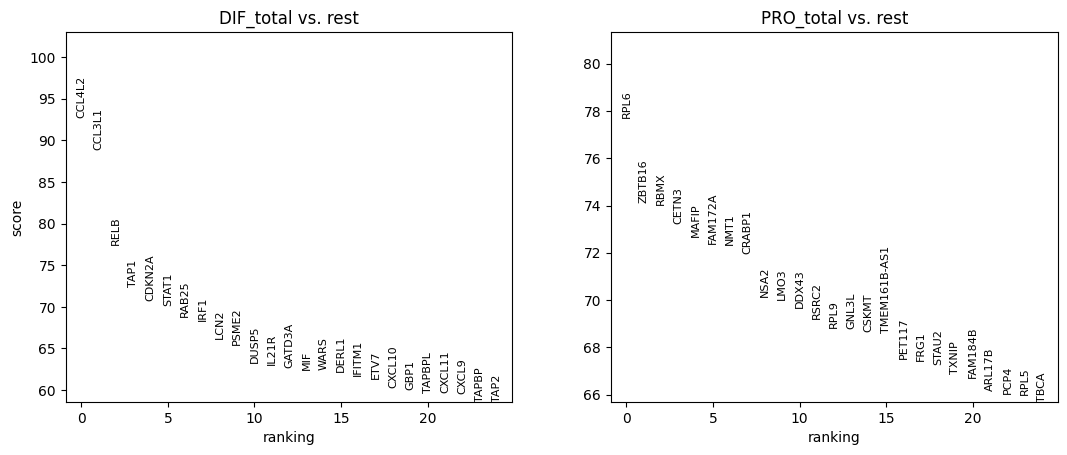

In [23]:
sc.tl.rank_genes_groups(adata, 'subtype_total', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

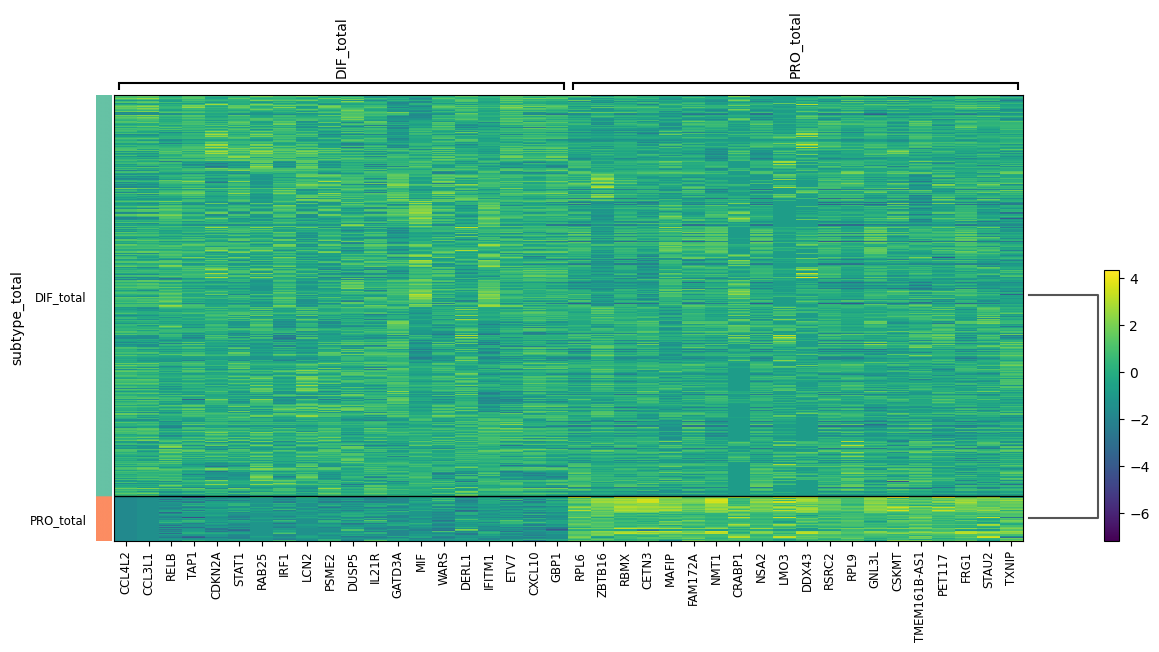

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, key="wilcoxon", groupby="subtype_total", show_gene_labels=True)


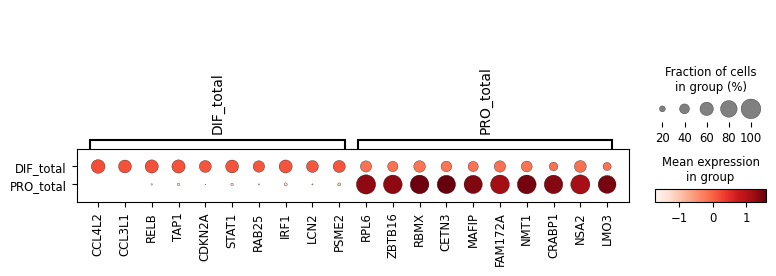

In [25]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key="wilcoxon", groupby="subtype_total")


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


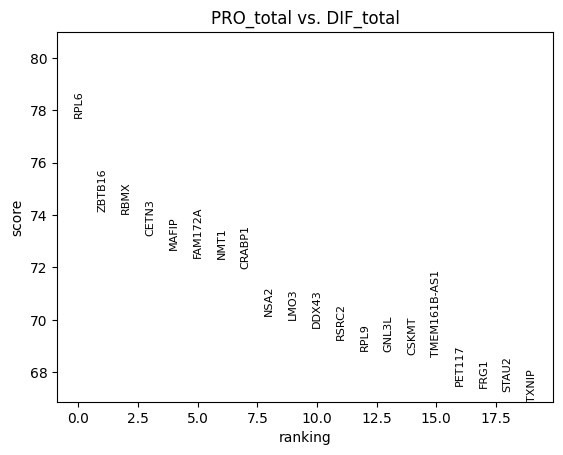

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


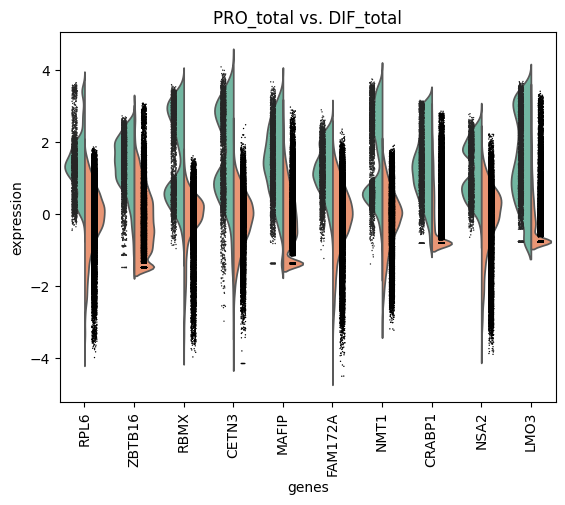

In [26]:
sc.tl.rank_genes_groups(adata, 'subtype_total', groups=['PRO_total'], reference='DIF_total', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['PRO_total'], n_genes=20)
sc.pl.rank_genes_groups_violin(adata, groups='PRO_total', n_genes=10)


In [27]:
wc = adata.uns['wilcoxon']['names']["PRO_total"]
wc[0:100]

array(['RPL6', 'ZBTB16', 'RBMX', 'CETN3', 'MAFIP', 'FAM172A', 'NMT1',
       'CRABP1', 'NSA2', 'LMO3', 'DDX43', 'RSRC2', 'RPL9', 'GNL3L',
       'CSKMT', 'TMEM161B-AS1', 'PET117', 'FRG1', 'STAU2', 'TXNIP',
       'FAM184B', 'ARL17B', 'PCP4', 'RPL5', 'TBCA', 'FAM133B', 'SYF2',
       'C2orf49', 'GABARAP', 'RPS6', 'MT-ATP8', 'RPL11', 'GIGYF2', 'SYNC',
       'SURF6', 'KANSL2', 'TMA16', 'MT-ND4L', 'DPH5', 'AC004540.2',
       'DHX40', 'CCDC66', 'AC011445.2', 'DFFB', 'EEF1B2', 'RPS3A',
       'WAC-AS1', 'RFC1', 'FBL', 'C2orf40', 'AKT2', 'RPS24', 'FKBP5',
       'ANKRA2', 'ZNF718', 'FRA10AC1', 'CMTR1', 'MTREX', 'PPP2R5D',
       'RPS8', 'FAM215B', 'MED4', 'ATG10', 'SCRG1', 'GIGYF1', 'SNHG25',
       'C1orf131', 'PRPF18', 'MT-ND2', 'RPL7', 'AMD1', 'THOC1', 'FCF1',
       'RBBP4', 'PRPF4B', 'NCBP3', 'MUC20-OT1', 'ZC3H15', 'MIS12', 'RERE',
       'METTL8', 'KCTD7', 'ING5', 'SDR42E2', 'AL392172.1', 'PCED1A',
       'OSGEPL1', 'RBM8A', 'G2E3', 'TMEM161B', 'PARP2', 'COL9A2', 'AP2B1',
       'AC10

# Plot results

In [28]:
# get consensusOV genes
consensus_genes = pd.read_csv(consensus_ov_gene_path)
consensus_genes = np.intersect1d(consensus_genes.gene, adata.var.gene_ids)

adata = adata[:, consensus_genes]

consensus_genes

array(['ADAMDEC1', 'ANXA1', 'APOBEC3G', 'BLMH', 'CACNA1C', 'CALD1',
       'CASP1', 'CLU', 'COL4A6', 'COL5A1', 'COL8A1', 'COPS3', 'CXCL10',
       'DDR2', 'DLC1', 'DLEC1', 'EFS', 'EVI2A', 'F2R', 'FCER1G', 'FN1',
       'FSCN1', 'FUT2', 'GAS7', 'GIMAP5', 'IL21R', 'KIF1A', 'KMO', 'LAG3',
       'LAMB1', 'LAPTM5', 'LCN2', 'LGALS1', 'MAPRE1', 'MAPRE2', 'MARCKS',
       'MARCKSL1', 'MFAP2', 'MGLL', 'MLPH', 'MMP14', 'NBL1', 'NETO2',
       'NNMT', 'NUAK1', 'PALLD', 'PCOLCE', 'PDPN', 'PDZK1IP1', 'PKIA',
       'PTGER2', 'RARRES3', 'RHOBTB3', 'RIN1', 'RUNX1', 'SALL2',
       'SCGB2A2', 'SLA', 'SLC31A2', 'SLC37A1', 'SMARCD1', 'SSH3',
       'STEAP3', 'STMN1', 'TCF7L1', 'TNFRSF14', 'TPST1', 'UBE2L6',
       'WIPF1'], dtype=object)

In [29]:
adata

View of AnnData object with n_obs × n_vars = 34000 × 69
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'Ovarian.cancer.cell', 'Fibroblast', 'Endothelial.cell', 'Monocyte', 'T.cell', 'B.cell', 'Plasma.cell', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'subtype_total'
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'subtype_colors', 'sample_id_colors', 'Y_max_colors', 'log1p', 'wilcoxon', 'subtype_total_colors', 'dendrogram_subtype_total', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [30]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,Ovarian.cancer.cell,Fibroblast,Endothelial.cell,Monocyte,T.cell,B.cell,Plasma.cell,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,subtype_total
0,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.215000,0.010000,0.260000,0.045000,0.215000,0.175000,0.080000,0.394,0.512,0.036,0.058,DIF,Endothelial.cell,DIF_total
1,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.030000,0.100000,0.030000,0.270000,0.020000,0.330000,0.220000,0.794,0.042,0.012,0.152,IMR,B.cell,DIF_total
2,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.380000,0.090000,0.025000,0.210000,0.045000,0.240000,0.010000,0.462,0.350,0.042,0.146,IMR,Ovarian.cancer.cell,DIF_total
3,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.020000,0.435000,0.165000,0.115000,0.070000,0.005000,0.190000,0.032,0.022,0.048,0.898,MES,Fibroblast,DIF_total
4,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.585000,0.220000,0.060000,0.015000,0.085000,0.030000,0.005000,0.098,0.498,0.140,0.264,DIF,Ovarian.cancer.cell,DIF_total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.008510,0.000712,0.009851,0.005425,0.003097,0.002376,0.970029,0.422,0.358,0.114,0.106,IMR,Plasma.cell,DIF_total
33996,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.005479,0.028999,0.008132,0.002173,0.015892,0.016113,0.923213,0.360,0.256,0.192,0.192,IMR,Plasma.cell,DIF_total
33997,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.003576,0.005394,0.004032,0.001560,0.017317,0.008581,0.959540,0.448,0.222,0.152,0.178,IMR,Plasma.cell,DIF_total
33998,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.018103,0.013037,0.034055,0.012250,0.081302,0.013003,0.828250,0.406,0.258,0.152,0.184,IMR,Plasma.cell,DIF_total


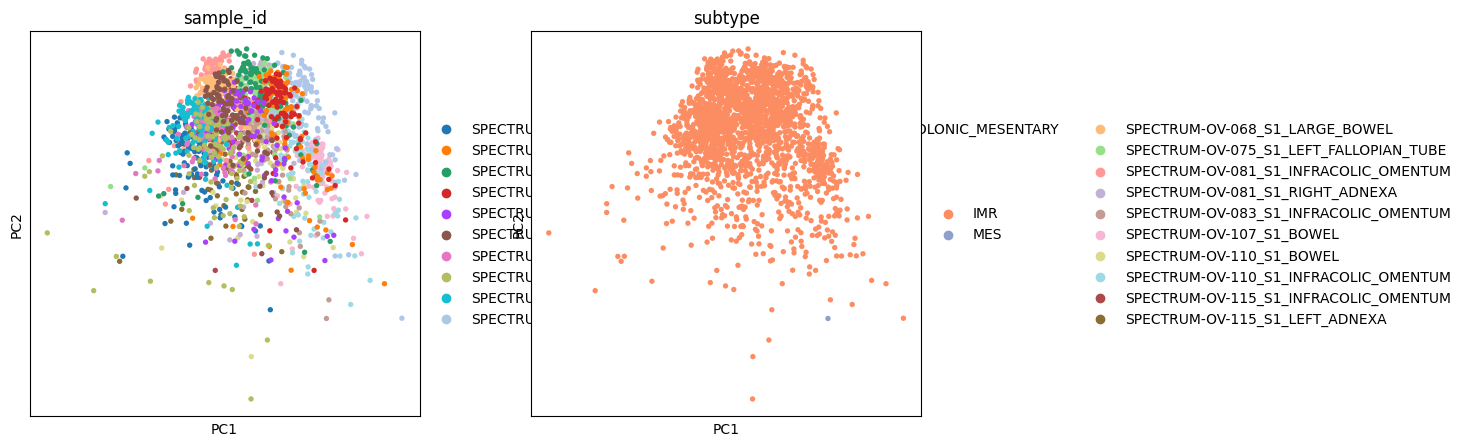

In [31]:
immune_ct = ["Monocyte"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['sample_id','subtype'])

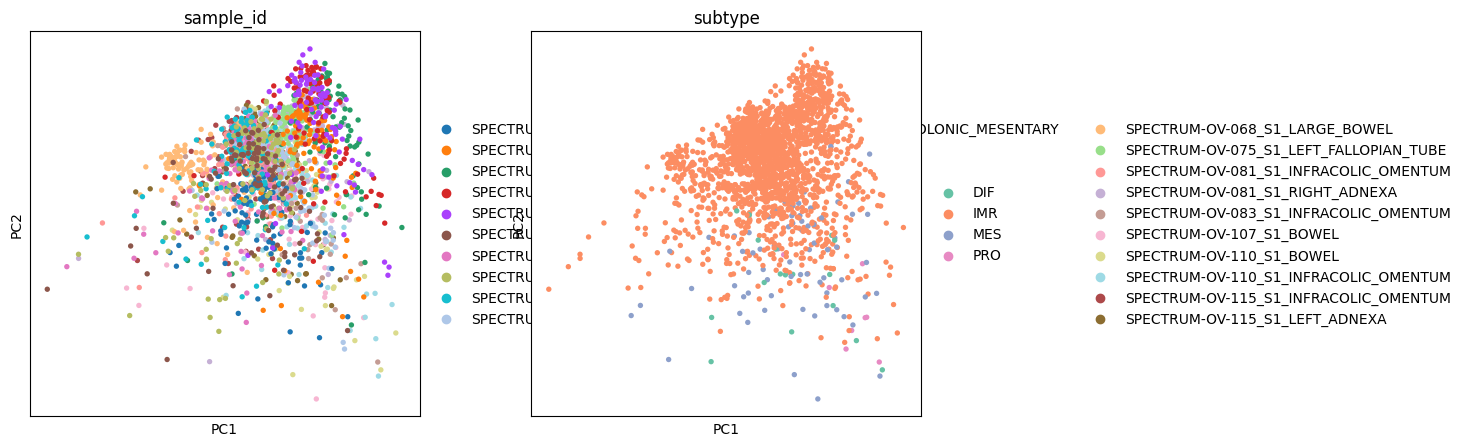

In [32]:
immune_ct = ["T.cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['sample_id','subtype'])

In [33]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,Ovarian.cancer.cell,Fibroblast,Endothelial.cell,Monocyte,T.cell,B.cell,Plasma.cell,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,subtype_total
0,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.215000,0.010000,0.260000,0.045000,0.215000,0.175000,0.080000,0.394,0.512,0.036,0.058,DIF,Endothelial.cell,DIF_total
1,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.030000,0.100000,0.030000,0.270000,0.020000,0.330000,0.220000,0.794,0.042,0.012,0.152,IMR,B.cell,DIF_total
2,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.380000,0.090000,0.025000,0.210000,0.045000,0.240000,0.010000,0.462,0.350,0.042,0.146,IMR,Ovarian.cancer.cell,DIF_total
3,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.020000,0.435000,0.165000,0.115000,0.070000,0.005000,0.190000,0.032,0.022,0.048,0.898,MES,Fibroblast,DIF_total
4,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref,0.585000,0.220000,0.060000,0.015000,0.085000,0.030000,0.005000,0.098,0.498,0.140,0.264,DIF,Ovarian.cancer.cell,DIF_total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.008510,0.000712,0.009851,0.005425,0.003097,0.002376,0.970029,0.422,0.358,0.114,0.106,IMR,Plasma.cell,DIF_total
33996,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.005479,0.028999,0.008132,0.002173,0.015892,0.016113,0.923213,0.360,0.256,0.192,0.192,IMR,Plasma.cell,DIF_total
33997,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.003576,0.005394,0.004032,0.001560,0.017317,0.008581,0.959540,0.448,0.222,0.152,0.178,IMR,Plasma.cell,DIF_total
33998,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref,0.018103,0.013037,0.034055,0.012250,0.081302,0.013003,0.828250,0.406,0.258,0.152,0.184,IMR,Plasma.cell,DIF_total


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


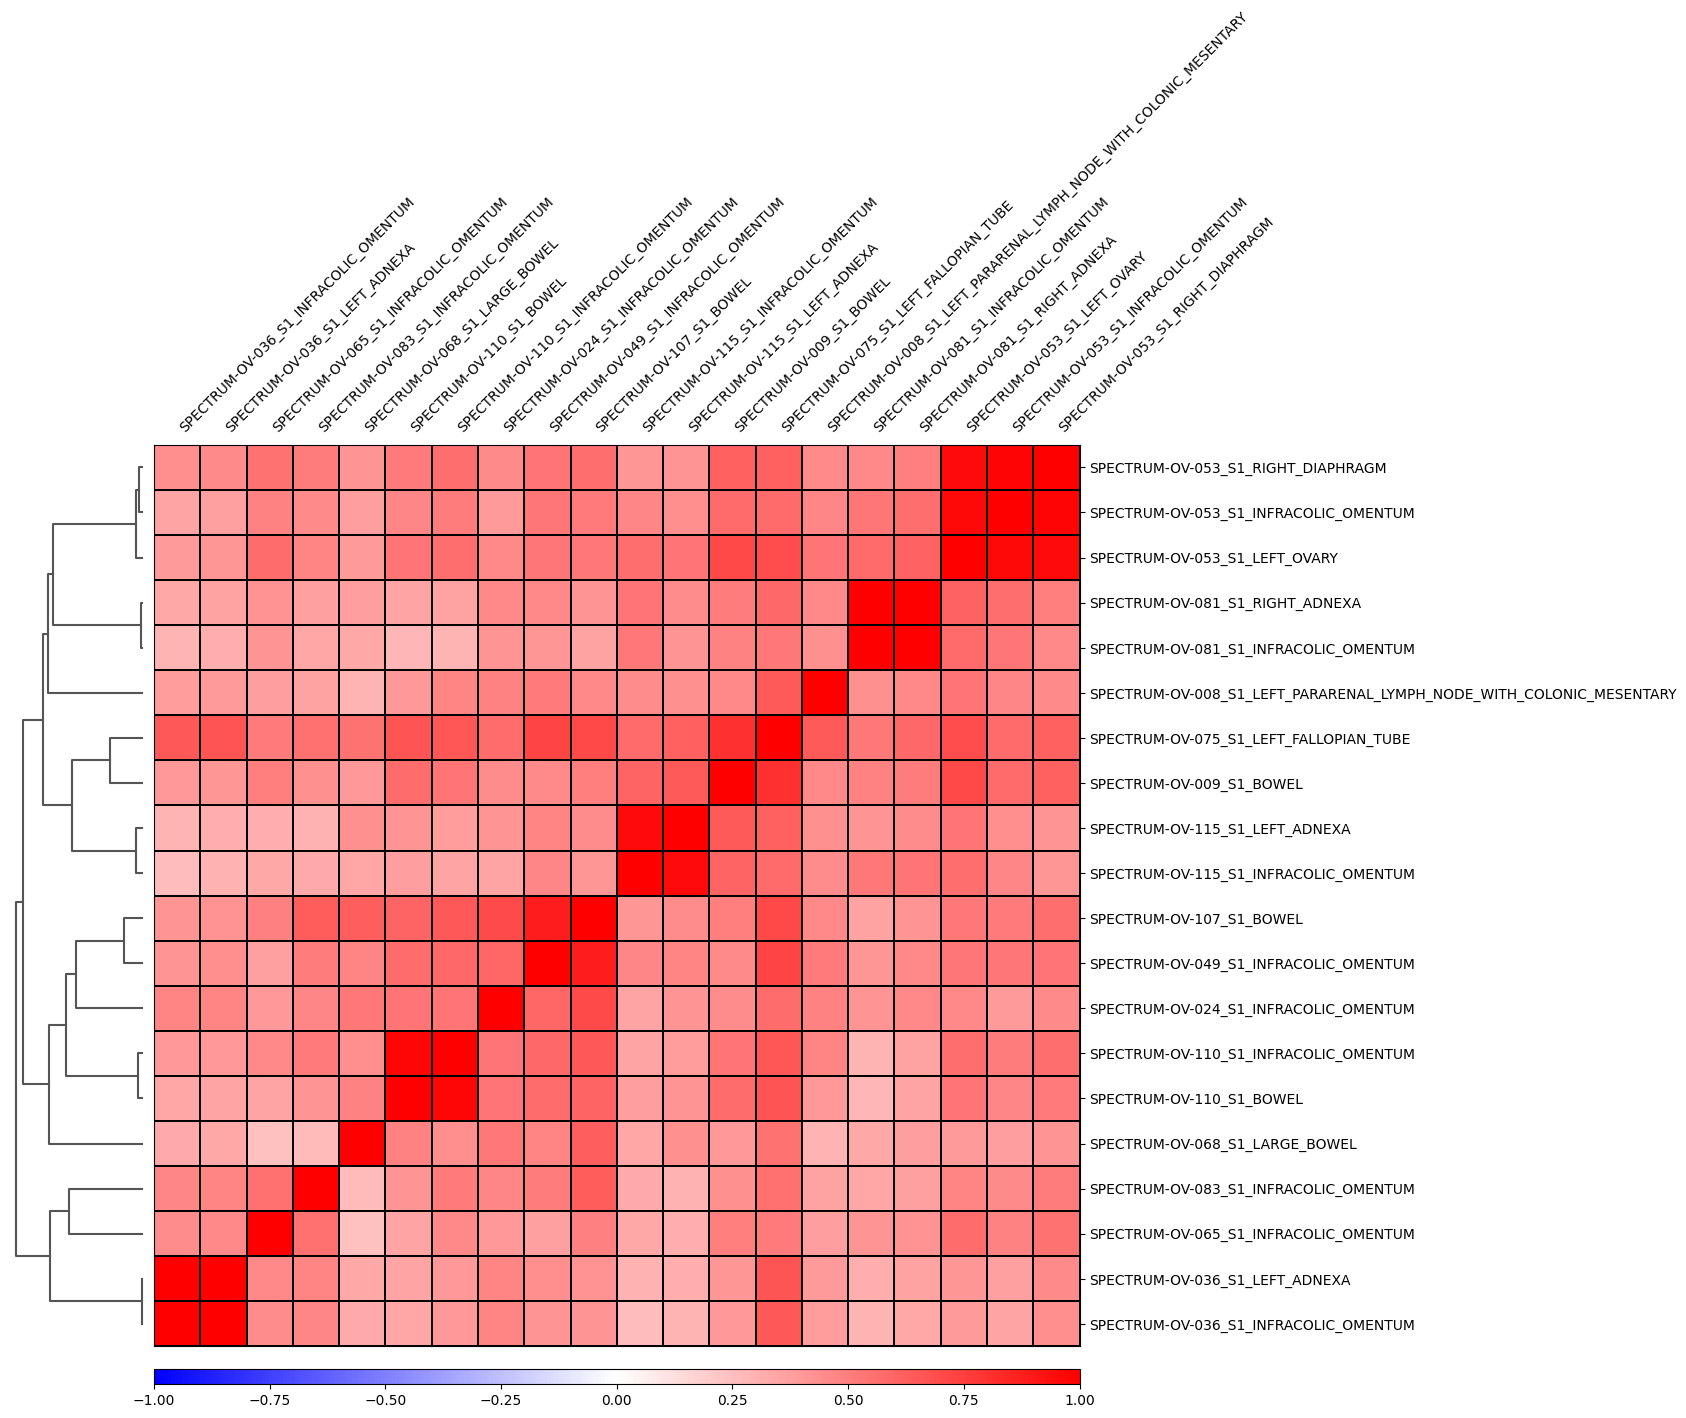

In [34]:
immune_ct = ["Ovarian.cancer.cell"]
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.where(np.logical_and(idx, adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(adata[idx], groupby="sample_id")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


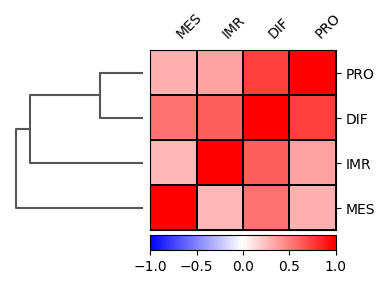

In [35]:
immune_ct = ["Ovarian.cancer.cell"]
idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

sc.pl.correlation_matrix(adata[idx], groupby="subtype")

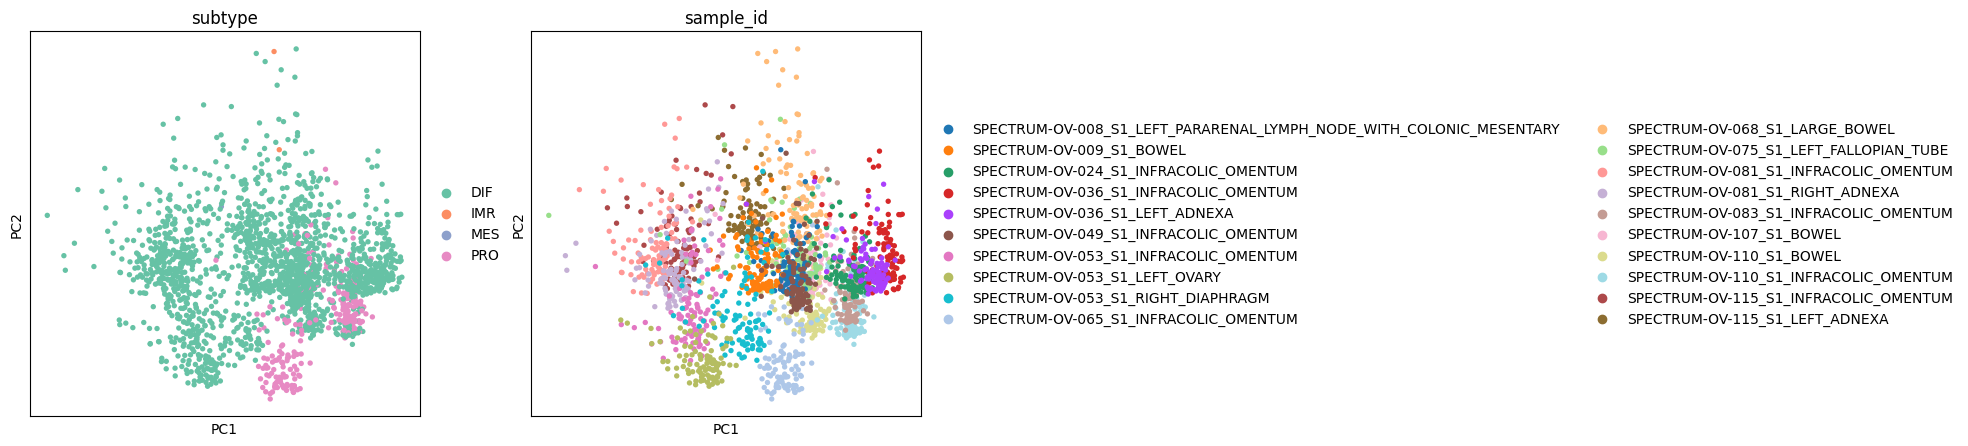

In [36]:
immune_ct = ["Ovarian.cancer.cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]


with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'])

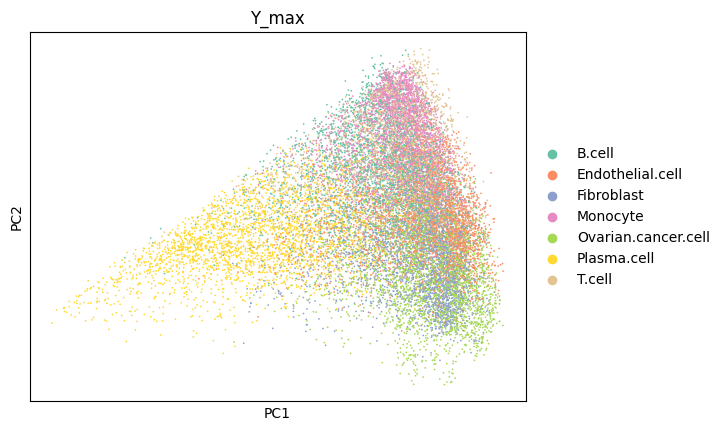

In [37]:
idx = np.where(adata.obs.cell_prop_type == "random" )[0]

sc.pl.pca(adata[idx], color='Y_max')